In [76]:
import yfinance as yf
import pandas as pd
import numpy as np

ticker = 'AAPL'
data = yf.download(ticker, start='2000-01-01', end='2025-01-01', interval = '1d')
data = data[['Open', 'Close', 'Low', 'High']]


/tmp/ipython-input-1683630603.py:6: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(ticker, start='2000-01-01', end='2025-01-01', interval = '1d')
[*********************100%***********************]  1 of 1 completed


In [77]:
# Function 1: Calculate 10-day period EMA on 1d intervals
def get_ema_signal(data):

    #past 10 days
    df_ema = data.copy()
    ema_period = 10;
    df_ema['EMA'] = df_ema['Close'].ewm(span=ema_period, adjust=False).mean()

    # Returns 1 for Buy, -1 for Sell, 0 for Neutral
    threshold = 0.001
    df_ema['EMA_Signal'] = np.where(
        df_ema['Close'] > df_ema['EMA'] * (1 + threshold), 1,
        np.where(df_ema['Close'] < df_ema['EMA'] * (1 - threshold), -1, 0)
    )
    return df_ema


In [78]:
# Function 2: Generate Heikin Ashi values
def get_heikin_ashi_values(data):
    """
    Calculates HA candles to reduce noise and identify trends.
    Focuses on 'shaved' candles for strength[cite: 291, 292].
    """
    df_ha = data.copy()
    # don't trade for the first month until the ha candles stabilize
    df_ha['HA_Close'] = (data['Open'] + data['High'] + data['Low'] + data['Close']) / 4
    df_ha['HA_Open'] = (data['Open'] + data['Close']) / 2
    for i in range(1, len(df_ha)):
      df_ha.iloc[i, df_ha.columns.get_loc('HA_Open')] = (df_ha.iloc[i-1]['HA_Open'] + df_ha.iloc[i-1]['HA_Close']) / 2

    df_ha['HA_High'] = df_ha[['High', 'HA_Open', 'HA_Close']].max(axis=1)
    df_ha['HA_Low'] = df_ha[['Low', 'HA_Open', 'HA_Close']].min(axis=1)

    # Potential improvement: improve the signal value (i.e. what if there's a miniscule lower wick)
    # Signal Logic: Green with no lower wick (1), Red with no upper wick (-1)
    df_ha['HA_Signal'] = 0
    df_ha.loc[(df_ha['HA_Close'] > df_ha['HA_Open']) & ((df_ha['HA_Open'] == df_ha['HA_Low']) | ((df_ha['HA_High'] - df_ha['HA_Close']) / (df_ha['HA_Open'] - df_ha['HA_Low']) > 4)) , 'HA_Signal'] = 1
    df_ha.loc[(df_ha['HA_Close'] < df_ha['HA_Open']) & ((df_ha['HA_Open'] == df_ha['HA_High']) | ((df_ha['HA_Close'] - df_ha['HA_Low']) / (df_ha['HA_High'] - df_ha['HA_Open']) > 4)), 'HA_Signal'] = -1

    for i in range(1, len(df_ha)):
        cur = bool(df_ha.iloc[i, df_ha.columns.get_loc('HA_Signal')].item() >= 0)
        last = bool(df_ha.iloc[i-1, df_ha.columns.get_loc('HA_Signal')].item() >= 0)
        if not (cur ^ last):
            df_ha.iloc[i, df_ha.columns.get_loc('HA_Signal')] += df_ha.iloc[i-1, df_ha.columns.get_loc('HA_Signal')]


    return df_ha

In [79]:
# Function 3: Corroborate and Execute
def corroborate_signals(df):

    combined = df.copy()
    #Only buy/sell if there's been 2 consecutive days of the current one without the other
    combined['Trade_Action'] = np.where((combined['EMA_Signal'] == 1) & (combined['HA_Signal'] > 1), "BUY",
                               np.where((combined['EMA_Signal'] == -1) & (combined['HA_Signal'] < -1), "SELL", "HOLD"))

    return combined

In [80]:
def backtest_efficiency(ticker, start_date="2005-01-01"):
    df = data.copy()
    df.columns = df.columns.get_level_values(0)

    # Apply Functions 1-3
    df = get_ema_signal(df)
    df = get_heikin_ashi_values(df)
    results = corroborate_signals(df)

    # calculate net account value

    results['Gain'] = 0
    results['Shares'] = 0
    results['Total Value'] = 0
    gain_idx = results.columns.get_loc('Gain')
    shares_idx = results.columns.get_loc('Shares')
    val_idx = results.columns.get_loc('Total Value')
    close_idx = results.columns.get_loc('Close')

    for i in range(31, len(results)):
        results.iloc[i, gain_idx] = results.iloc[i-1, gain_idx]
        results.iloc[i, shares_idx] = results.iloc[i-1, shares_idx]
        if results['Trade_Action'].iloc[i] == 'BUY':

            if results.iloc[i, shares_idx] < 0:
                results.iloc[i, gain_idx] -= abs(results.iloc[i, shares_idx]) * results.iloc[i, close_idx]
                results.iloc[i, shares_idx] = 0

            results.iloc[i, gain_idx] -= results.iloc[i, close_idx]
            results.iloc[i, shares_idx] += 1

        elif results['Trade_Action'].iloc[i] == 'SELL':
            if results.iloc[i, shares_idx] > 0:
                results.iloc[i, gain_idx] += abs(results.iloc[i, shares_idx]) * results.iloc[i, close_idx]
                results.iloc[i, shares_idx] = 0;

            results.iloc[i, gain_idx] += results.iloc[i, close_idx]
            results.iloc[i, shares_idx] -= 1

        current_val = (results.iloc[i, shares_idx] * results.iloc[i, close_idx]) + results.iloc[i, gain_idx]
        results.iloc[i, val_idx] = current_val
    return results

/tmp/ipython-input-1576925898.py:29: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '-0.8556817173957825' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  results.iloc[i, gain_idx] -= results.iloc[i, close_idx]
/tmp/ipython-input-1576925898.py:41: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.005623817443847656' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  results.iloc[i, val_idx] = current_val


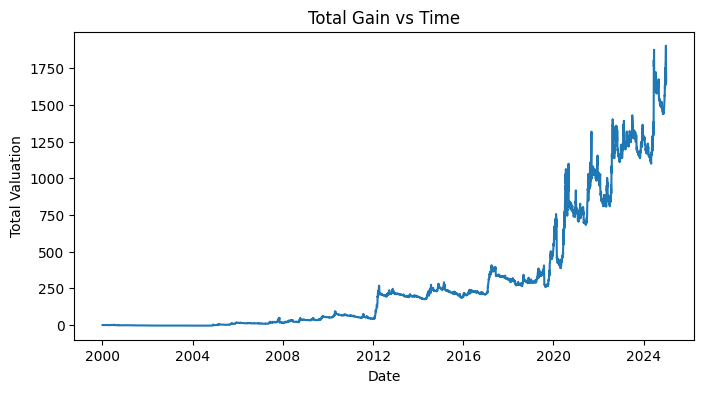

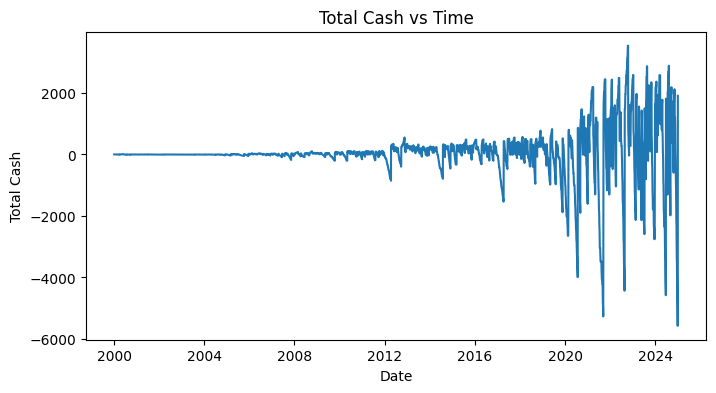

In [81]:
import matplotlib.pyplot as plt
results = backtest_efficiency(ticker)
plt.figure(figsize=(8, 4))
plt.title('Total Gain vs Time')
plt.xlabel('Date')
plt.ylabel('Total Valuation')
plt.plot(results['Total Value'])

plt.figure(figsize=(8, 4))
plt.title('Total Cash vs Time')
plt.xlabel('Date')
plt.ylabel('Total Cash')
plt.plot(results['Gain'])